<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 609 (delta 192), reused 231 (delta 159), pack-reused 302
Receiving objects: 100% (609/609), 14.34 MiB | 17.93 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.27G/1.28G [00:13<00:00, 70.0MB/s]
100% 1.28G/1.28G [00:13<00:00, 99.9MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## 1.3 Balance the dataset

In [8]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [16]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2403.03253,Turbocharging constraints on dark matter subst...,"['astro-ph.CO', 'astro-ph.GA']",Strong gravitational lensing provides a pure...
1,2306.13475,Cosmological Simulations of Galaxy Groups and ...,"['astro-ph.CO', 'astro-ph.GA']",The thermal Sunyaev-Zeldovich (SZ) effect se...
2,2011.05345,Cosmology dependency of halo masses and concen...,"['astro-ph.CO', 'astro-ph.GA']",We employ a set of Magneticum cosmological h...
3,2303.10175,Measuring galaxy cluster mass profiles into th...,"['astro-ph.CO', 'astro-ph.GA']",We probe the dynamical mass profiles of 10 g...
4,2308.04614,Probing Ultra-late Reionization: Direct Measur...,"['astro-ph.CO', 'astro-ph.GA']","The mean free path of ionizing photons, $\la..."


Visualize the dataset distribution.

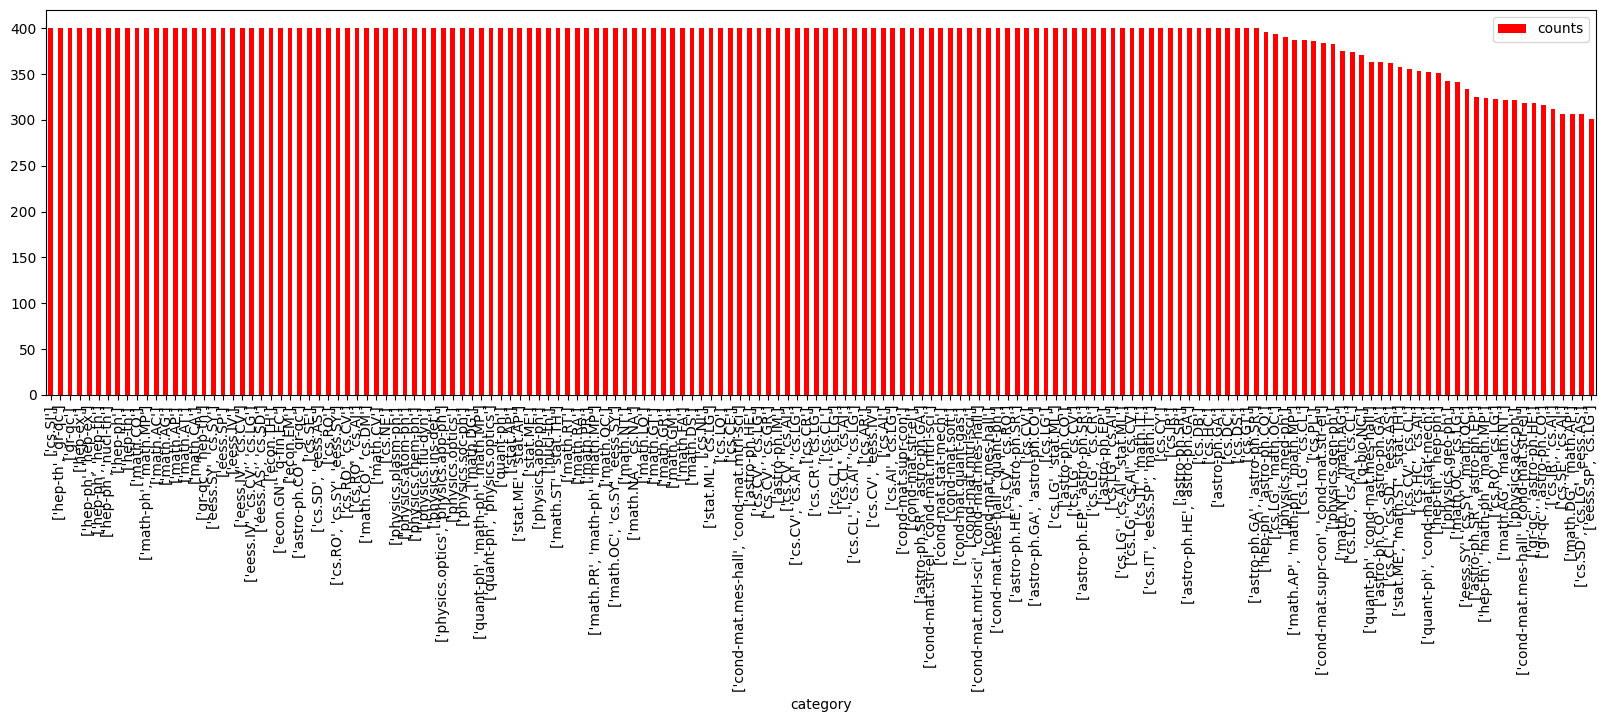

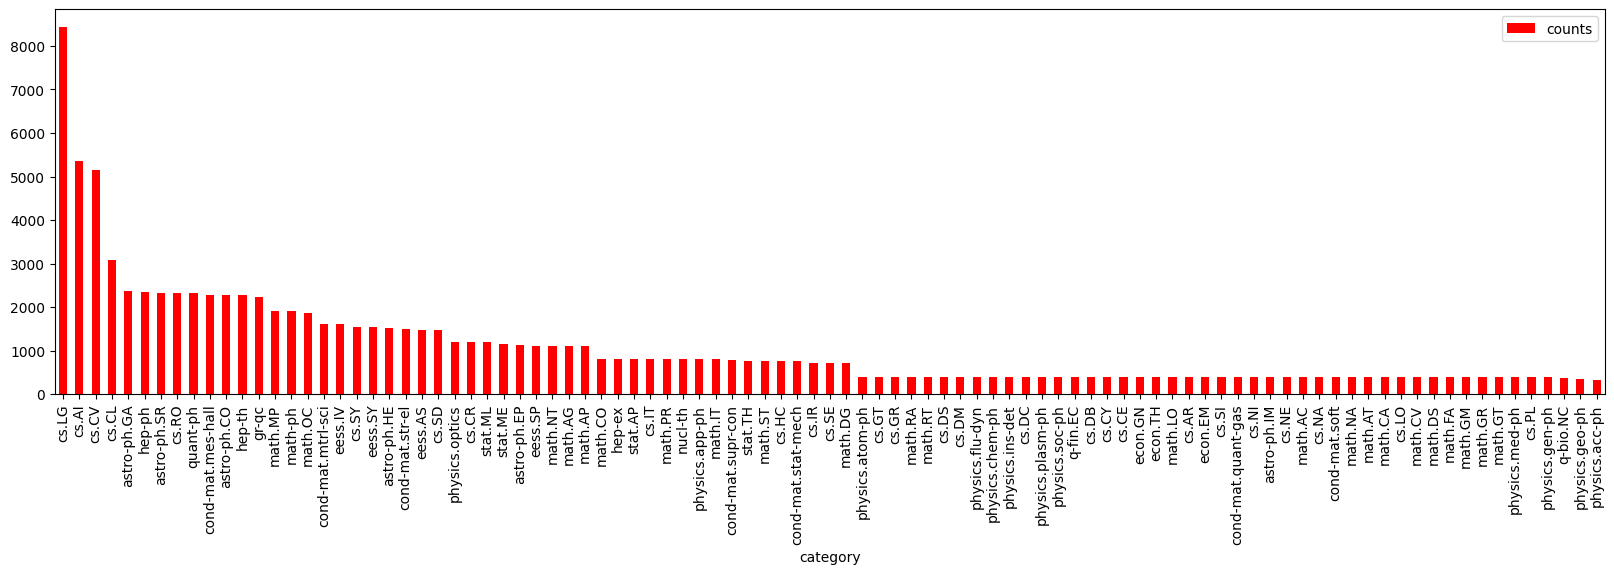

In [17]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [18]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
6288,2402.06792,Resonances involving integer magnons and spin-...,"[cond-mat.mes-hall, cond-mat.str-el]",We conduct an experimental study of high-mob...
6289,2207.09601,Evidence for Exciton Crystals in a 2D Semicond...,"[cond-mat.mes-hall, cond-mat.str-el]",Two-dimensional (2D) transition metal dichal...
6290,2308.02638,Nature of even and odd magic angles in helical...,"[cond-mat.mes-hall, cond-mat.str-el]",Helical twisted trilayer graphene exhibits z...
6291,2308.09927,Revisiting thermoelectric transport across str...,"[cond-mat.mes-hall, cond-mat.str-el]",Using Green's function equation of motion wi...
6292,2305.01162,Role of bias and tunneling asymmetries in nonl...,"[cond-mat.mes-hall, cond-mat.str-el]",We study how bias and tunneling asymmetries ...


## 1.4 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [19]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 30059 articles.
The dataset contains 20000 articles.


# 2) Text-processing

In [12]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [20]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

100%|██████████| 20000/20000 [03:33<00:00, 93.81it/s] 


,id,title,category,abstract,clean_abstract,clean_title
62678,2306.03968,Stochastic Marginal Likelihood Gradients using...,"[stat.ML, cs.LG]",Selecting hyperparameters in deep learning g...,select hyperparameter deep learning greatly im...,stochastic marginal likelihood gradients use n...
25888,2301.10737,Distributed Control of Partial Differential Eq...,"[cs.LG, math.OC]",We present a convolutional framework which s...,present convolutional framework significantly ...,distribute control partial differential equati...
25799,2302.02212,Federated Temporal Difference Learning with Li...,"[cs.LG, math.OC]",We initiate the study of federated reinforce...,initiate study federate reinforcement learning...,federated temporal difference learn linear fun...
22848,2307.09782,ZeroQuant-FP: A Leap Forward in LLMs Post-Trai...,"[cs.LG, cs.AI, cs.CL]",In the complex domain of large language mode...,complex domain large language model llms strik...,zeroquant fp leap forward llms post training q...
57982,2307.14821,Experimental validation of particle-in-cell/Mo...,[physics.plasm-ph],Plasma simulations are powerful tools for un...,plasma simulation powerful tool understand fun...,experimental validation particle cell monte ca...


In [21]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
13201,2310.06254,Get the gist? Using large language models for ...,"[cs.CL, cs.AI]",In many NLP applications that involve interp...,nlp application involve interpret sentence ric...,gist use large language model shot decontextua...,gist use large language model shot decontextua...
24077,2403.14843,Local Causal Discovery with Linear non-Gaussia...,"[cs.LG, cs.AI]",Local causal discovery is of great practical...,local causal discovery great practical signifi...,local causal discovery linear non gaussian cyc...,local causal discovery linear non gaussian cyc...
41139,2307.11634,Twisted Index on Hyperbolic Four-Manifolds,"[hep-th, math-ph, math.MP]",We introduce the topologically twisted index...,introduce topologically twist index dimensiona...,twist index hyperbolic manifolds,twist index hyperbolic manifolds introduce top...
11765,2403.15586,Generative AI in Education: A Study of Educato...,[cs.AI],The rapid advancement of artificial intellig...,rapid advancement artificial intelligence ai e...,generative ai education study educators awaren...,generative ai education study educators awaren...
25000,2307.13771,Accuracy Improvement in Differentially Private...,"[cs.LG, cs.CR]",Machine learning (ML) models can memorize tr...,machine learning ml model memorize training da...,accuracy improvement differentially private lo...,accuracy improvement differentially private lo...


# 3) Multilabel Classification
Given an article:
- its feature X will be the cleaned text
- its label y will be its lists of categories (in a one-hot-encoding)

In [18]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.4 MB/s eta 0:00:00


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

In [20]:
path = "./processed_dataframe.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
19995,2404.14057,Bored to Death: Artificial Intelligence Resear...,['cs.CL'],Background: Recent advancements in Artificia...,background recent advancement artificial intel...,bore death artificial intelligence research re...,bore death artificial intelligence research re...
19996,1910.01088,Dark energy and inflation invoked in CCGG by l...,"['gr-qc', 'astro-ph.CO']",The cosmological implications of the Covaria...,cosmological implication covariant canonical g...,dark energy inflation invoke ccgg locally cont...,dark energy inflation invoke ccgg locally cont...
19997,2311.01687,A Computational Study and Parameterisation of ...,['physics.chem-ph'],Phosphatidylinositol phosphates (PIPs) are m...,phosphatidylinositol phosphate pip membrane ph...,computational study parameterisation phosphati...,computational study parameterisation phosphati...
19998,2401.05116,Is there a size premium for nations?,"['econ.GN', 'q-fin.EC']",This paper examines whether there is a premi...,paper examine premium country size study signi...,size premium nation,size premium nation paper examine premium coun...
19999,2402.08114,Active Preference Learning for Large Language ...,"['cs.LG', 'cs.AI', 'cs.CL']",As large language models (LLMs) become more ...,large language model llms capable fine tuning ...,active preference learn large language model,active preference learn large language model l...


In [21]:
# Preparing X (features).
X = df["clean_text"]


# Preparing y (labels) in a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Visualize y as a one-hot encoding.

In [22]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.GA,astro-ph.HE,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.quant-gas,cond-mat.str-el,cs.AI,cs.CL,cs.CV,...,math.NA,math.RT,nucl-th,physics.chem-ph,physics.gen-ph,physics.ins-det,physics.med-ph,q-fin.EC,quant-ph,stat.ML
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
19998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Do the classification.

In [23]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

accuracy = 0.5546666666666666

                    precision    recall  f1-score   support

       astro-ph.CO       0.92      0.94      0.93       850
       astro-ph.GA       0.89      0.77      0.83       196
       astro-ph.HE       0.70      0.47      0.56        89
 cond-mat.mes-hall       0.94      0.91      0.93       568
 cond-mat.mtrl-sci       0.74      0.65      0.69       190
cond-mat.quant-gas       0.97      0.79      0.87       108
   cond-mat.str-el       0.68      0.31      0.42        81
             cs.AI       0.82      0.86      0.84      1667
             cs.CL       0.91      0.89      0.90      1078
             cs.CV       0.87      0.74      0.80       481
             cs.CY       0.70      0.27      0.39        96
             cs.DS       0.96      0.76      0.85       108
             cs.GR       0.77      0.72      0.74        92
             cs.HC       0.87      0.44      0.59        88
             cs.IR       0.95      0.69      0.80        81
        

Plot confusion matrices.

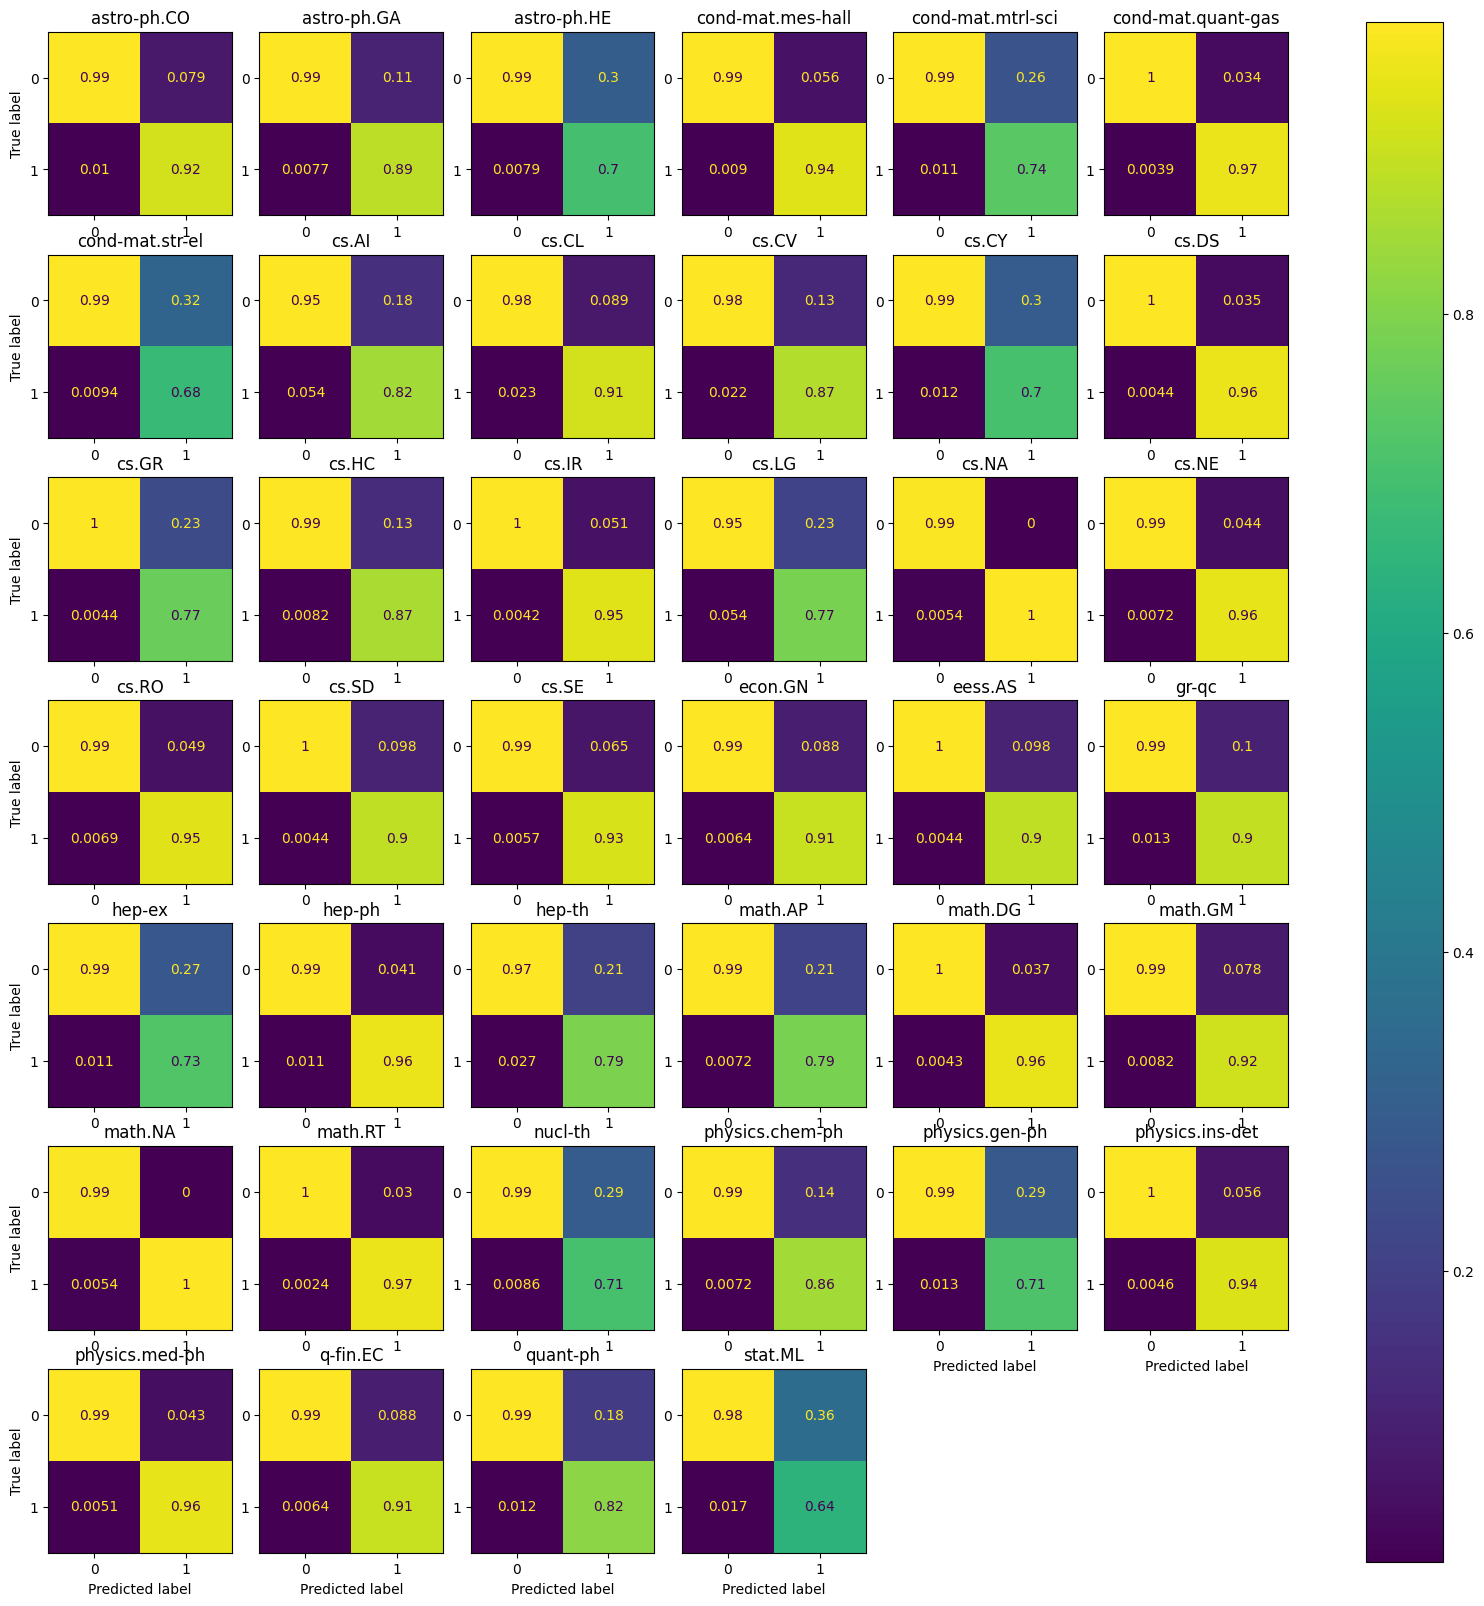

In [24]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [25]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('physics.med-ph',)
predicted: ('physics.med-ph',)
--------------------
  true   : ('cond-mat.mes-hall', 'cond-mat.mtrl-sci')
predicted: ('cond-mat.mes-hall', 'quant-ph')
--------------------
  true   : ('gr-qc',)
predicted: ('astro-ph.HE', 'gr-qc')
--------------------
  true   : ('cs.AI', 'cs.LG', 'stat.ML')
predicted: ('cs.AI', 'cs.LG')
--------------------
  true   : ('physics.chem-ph',)
predicted: ('physics.chem-ph',)
--------------------
  true   : ('cond-mat.quant-gas',)
predicted: ()
--------------------
  true   : ('cs.NE',)
predicted: ('cs.NE',)
--------------------
  true   : ('astro-ph.CO',)
predicted: ('astro-ph.CO', 'hep-ph')
--------------------
  true   : ('cs.AI', 'cs.CV')
predicted: ('cs.CV',)
--------------------
  true   : ('hep-ph', 'nucl-th')
predicted: ('hep-ph', 'nucl-th')


Plot the ROC curve.

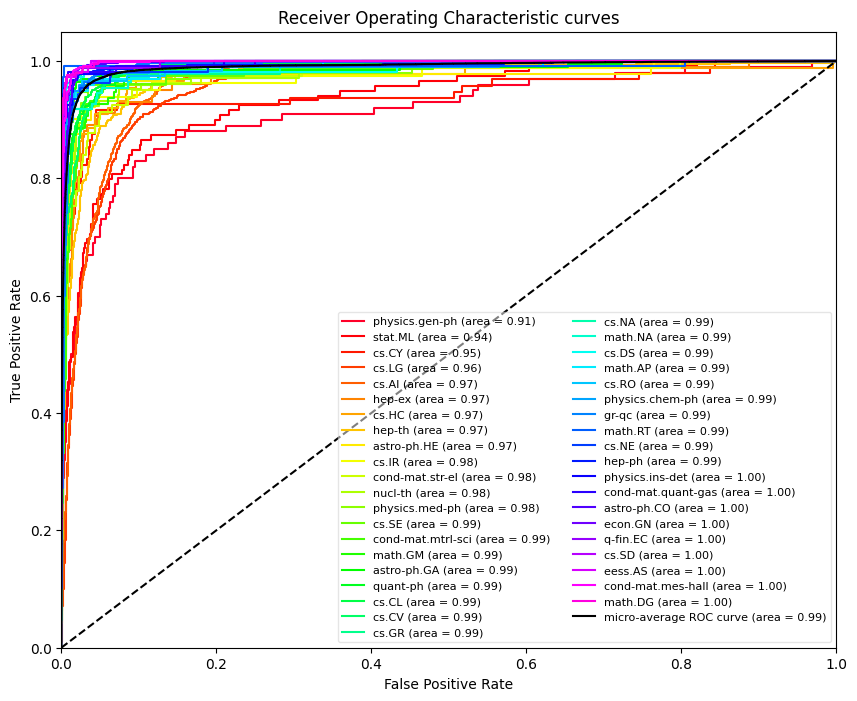

In [26]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

# 4) Keywords extraction

In [10]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.3 MB/s eta 0:00:00


In [11]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                         kw_model=kw_model,
                                         seed=x["clean_title"].split(" "))

df["keywords"] = df.progress_apply(extraction, axis=1)

df.to_csv(f"./keywords.csv", index=False) # Save to csv
df.head()

  3%|▎         | 566/20000 [20:42<12:41:28,  2.35s/it]

# 4) Multilabel Classification #2
Repeat the classification.
This time, given an article:
- its feature X will be the list of its keywords
- its label y will be its lists of categories (in a one-hot-encoding)


In [ ]:
path = "./keywords.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

In [ ]:
# Preparing X (features).
X = df["keywords"]


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [ ]:
y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

Plot confusion matrices.

In [ ]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

Plot the ROC curve.

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)